# Pangeo demo: Getting Ready for NiSAR (GRFN)

This notebook demonstrates advanced analysis of GRFN InSAR data using Pangeo cloud-based software.

The images total 25Gb: over 200 unwrapped phase interferograms with 30x30m posting

In particular, we'll explore data exploration and analysis with Python tools. **The computation is running on the Cloud next to the data, and only figures and a small image subset is downloaded locally.** 

To run each code cell, use 'shift+enter'

**Warning!** you can modify this notebook, upload files, and save files listed on the left (right-click and you will see a download option). BUT!... it is an ephemeral demo. Work will be lost if you leave this idle for a bit. Everything shuts down automatically.

In [ ]:
# Import python packages
import rasterio
from rasterio.mask import mask
import xarray as xr
import numpy as np
import hvplot.xarray
import hvplot.pandas
import holoviews as hv
import gcsfs
import intake
import pandas as pd
import geopandas as gpd
import os.path
from dask_kubernetes import KubeCluster
from dask.distributed import Client
%matplotlib inline

## Launch a Kubernetes Cluster

we can use a kubernetes cluster to increase our computational resources

10 workers are selected by default (each w/ customizable CPUs and RAM). When parallizeable computations are requested, you'll see the cluster activity on the right hand dashboards

In [2]:
cluster = KubeCluster(n_workers=10)
cluster

In [3]:
client = Client(cluster)

## List files on Cloud Storage

In [4]:
# We've converted GRFN interferograms to cloud-optimized geotiffs
# And made them available in a public cloud bucket
bucket = 'grfn-hawaii-124-cog'

# This creates a virtual local file listing
fs = gcsfs.GCSFileSystem(project='pangeo-181919')
images = fs.ls(f'pangeo-data/{bucket}')

print('Number of images:', len(images))
print('First image:', images[0])

Number of images: 213
First image: pangeo-data/grfn-hawaii-124-cog/20180725-20180719-unw.geo.tif


In [5]:
# Each of these images has an associates public URL:
# We'll use pandas to make a sorted dataframe of all the images
def parse_name(gsPath, key='date1'):
    ''' grab project, bucket, date1, date2, format from file name, return dictionary'''
    pattern = '{project}/{bucket}/{date1:%Y%m%d}-{date2:%Y%m%d}-{format}'
    parsed = intake.source.utils.reverse_format(pattern, gsPath)
    val = parsed[key]
    return val

def make_dataframe(images):
    ''' organize pandas dataframe by parsing filename'''
    df = pd.DataFrame(dict(gs=images))
    df = df.sort_values('gs').reset_index(drop=True)
    df['url'] = 'http://storage.googleapis.com/' + df.gs.str[:]
    df['date1'] = df.gs.apply(parse_name, args=('date1',))
    df['date2'] = df.gs.apply(parse_name, args=('date2',))
    df['dt'] = df.date1 - df.date2
    return df

In [6]:
df = make_dataframe(images)
print('Total images:', len(df))
print('First date:', df.date2.iloc[0])
print('Last date:', df.date1.iloc[-1])
df.head()

Total images: 213
First date: 2015-02-11 00:00:00
Last date: 2018-08-12 00:00:00


gs  \
0  pangeo-data/grfn-hawaii-124-cog/20150506-20150...   
1  pangeo-data/grfn-hawaii-124-cog/20150518-20150...   
2  pangeo-data/grfn-hawaii-124-cog/20150530-20150...   
3  pangeo-data/grfn-hawaii-124-cog/20150530-20150...   
4  pangeo-data/grfn-hawaii-124-cog/20150611-20150...   

                                                 url      date1      date2  \
0  http://storage.googleapis.com/pangeo-data/grfn... 2015-05-06 2015-02-11   
1  http://storage.googleapis.com/pangeo-data/grfn... 2015-05-18 2015-05-06   
2  http://storage.googleapis.com/pangeo-data/grfn... 2015-05-30 2015-05-06   
3  http://storage.googleapis.com/pangeo-data/grfn... 2015-05-30 2015-05-18   
4  http://storage.googleapis.com/pangeo-data/grfn... 2015-06-11 2015-05-30   

       dt  
0 84 days  
1 12 days  
2 24 days  
3 12 days  
4 12 days

## Read Cloud-optimized geotiffs (COGs)

In [7]:
# Rasterio uses the gdal vsicurl system to access files
# on a cloud server
env = rasterio.Env(GDAL_DISABLE_READDIR_ON_OPEN='EMPTY_DIR',
                  CPL_VSIL_CURL_USE_HEAD=False,
                  CPL_VSIL_CURL_ALLOWED_EXTENSIONS='TIF',
                 )

In [8]:
# Read the first file in the set of images into xarray DataArray (w/ dask)
# note this is very fast b/c only metadata is downloaded to local memory
# chunks are based on cloud-optimized geotiff internal tiling
xchunk = 512
ychunk = 512
with env:
    da = xr.open_rasterio(df.url[0], parse_coordinates=True, chunks={'band': 1, 'x': xchunk, 'y': ychunk})

## Create an xarray DataSet

In [9]:
# Since all these images are pre-aligned ('analysis ready')
# we get best performance loading w/o metadata & coordinate checking
def create_dataset(df, chunks={'band': 1, 'x': 5120, 'y': 512}):
    # Note: this takes a minute b/c coordinate alignment is checked
    from ipywidgets import IntProgress
    from IPython.display import display
    probar = IntProgress(value=0, min=0, max=len(df), step=1, 
                         description='Loading:')
    display(probar)
    #print(rasterio.env.getenv())
    datasets = []
    # Create dataset to fill based on first image
    da = xr.open_rasterio(df.url[0], 
                          parse_coordinates=True, 
                          chunks=chunks) 
    probar.value += 1
    datasets.append(da.to_dataset(name='unw'))
    
    # Loop over remaining images to fill array
    for i,row in df[1:].iterrows():
        probar.value += 1
        url = row.url
        
        da = xr.open_rasterio(url, parse_coordinates=False, chunks=chunks)
        datasets.append(da.to_dataset(name='unw'))
    
    ds = xr.concat(datasets, dim='band')
    ds.coords['band'] = np.arange(len(df))
    return ds

In [10]:
with env:
    DS = create_dataset(df)

IntProgress(value=0, description='Loading:', max=213)

In [11]:
print('Dataset size (Gb): ', DS.nbytes/1e9)

Dataset size (Gb):  25.116460892


In [12]:
## Add a coastline water mask 

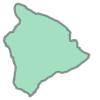

In [13]:
# Add a coastline mask to the dataset
# Land water mask (WGS84latlon epsg:4326)
gf = gpd.read_file("hawaii-gshhs.geojson")
gf.geometry.iloc[0]

In [14]:
# NOTE shapefle rasterization and projection from WGS84 to UTM
with rasterio.open(df.url.iloc[0]) as src:
    projected = gf.to_crs(src.crs)
    out_image, out_transform = mask(src, projected.geometry.values, indexes=1)
    
water = (out_image == 0)
DS.coords['mask'] = (('y', 'x'), water)
DSmasked = DS.where(DS.mask == False).chunk(chunks={'band': 1, 'x': 5120, 'y': 512})

In [15]:
DSmasked

<xarray.Dataset>
Dimensions:  (band: 213, x: 4649, y: 6341)
Coordinates:
  * x        (x) float64 1.722e+05 1.723e+05 1.723e+05 ... 3.117e+05 3.117e+05
  * y        (y) float64 2.214e+06 2.214e+06 2.214e+06 ... 2.024e+06 2.024e+06
  * band     (band) int64 0 1 2 3 4 5 6 7 8 ... 205 206 207 208 209 210 211 212
    mask     (y, x) bool dask.array<shape=(6341, 4649), chunksize=(512, 4649)>
Data variables:
    unw      (band, y, x) float32 dask.array<shape=(213, 6341, 4649), chunksize=(1, 512, 4649)>

## Interactive visualization with holoviews

**NOTE:** you may need to resize this pane to see all the buttons (drag grey separator bar to the right)

* Once in an xarray DataSet, hvplot can easily display images interactively:
* Note column of buttons on upper right side of figure.
* In addition to buttons, there is a time slider for band selection
    * click slider button and use arrow keys for fine control
* Box zoom button updates displayed resolution on the fly
* Moving cursor over image gives coordinates and unwrapped phase value

In [16]:
img = DSmasked.hvplot('x', 'y', groupby='band', dynamic=True, rasterize=True, 
                      width=700, height=500, cmap='magma')

limits = hv.streams.RangeXY(source=img)

img

:DynamicMap   [band]
   :Image   [x,y]   (unw)

# Save current view / subset

We can save a local copy of the current image with a function.

* select band=1 in interactive image browser above
    * zoom into volcano deformation zone in south (bright area)
        * run 2 cells below to save the local image subset
            * a geotiff will appear in the file browser on the left
                * right click the file and select 'download to get it on your laptop'

In [32]:
def get_src(img):
    ''' get current image displayed '''
    image_no = img.callback.args
    image_url = df.url.iloc[image_no]

    return image_url


def get_window(src, img):
    ''' get current rasterio window from holoviews plot '''
    limits = img.streams[1]
    if limits.x_range == None:
        bounds = src.bounds
    else:
        bounds = (limits.x_range[0], limits.y_range[0], limits.x_range[1], limits.y_range[1])
    uly,ulx = src.index(bounds[0], bounds[3])
    lry,lrx = src.index(bounds[2], bounds[1])

    width = lrx - ulx
    height = lry - uly

    return rasterio.windows.Window(ulx, uly, width, height)

def save_current_view(img, name='local-image.tif'):
    from ipywidgets import IntProgress
    from IPython.display import display
    probar = IntProgress(value=0, min=0, max=4, step=1, 
                         description='Saving:')
    display(probar)     
    
    with env:
        image_url = get_src(img)
        print(f'Saving {image_url}...')
        with rasterio.open(image_url) as src:
            probar.value +=1
            profile = src.profile.copy()
            window = get_window(src, img)
            win_transform = src.window_transform(window)
            probar.value +=1
            data = src.read(1, window=window)
        
        profile.update({
                'dtype': 'float32',
                'height': data.shape[0],
                'width': data.shape[1],
                'blockxsize': 256,
                'blockysize': 256,
                'transform': win_transform})  
        probar.value += 1
        localname = 'subset-' + os.path.basename(src.name)
        with rasterio.open(localname, 'w', **profile) as dst:
            dst.write_band(1, data) 
    probar.value +=1
    
    return localname

In [33]:
localname = save_current_view(img)

IntProgress(value=0, description='Saving:', max=4)

Saving http://storage.googleapis.com/pangeo-data/grfn-hawaii-124-cog/20150518-20150506-unw.geo.tif...


In [34]:
# Load and plot the saved subset to verify it's the same
# Since this is only a single file, we won't load with dask
with env:
    with rasterio.open(localname) as src:
        print(src.profile)
        da = xr.open_rasterio(src.name)
da.hvplot('x', 'y', groupby='band', dynamic=True, rasterize=True, 
          width=700, height=500, cmap='magma')

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 408, 'height': 905, 'count': 1, 'crs': CRS({'init': 'epsg:32605'}), 'transform': Affine(30.0, 0.0, 250110.0,
       0.0, -30.0, 2152920.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}


:DynamicMap   [band]
   :Image   [x,y]   (value)

# Parallel computations

With xarray DataSets, we can do parallel computations on the KubeCluster, using dask behind the scenes. Here is a simple example getting the mean phase value for each interferogram

In [35]:
def get_xarray_selection(img, band=False):
    ''' get selection dictionary from hvplot'''
    selection = {}
    selection['x'] = slice(*limits.x_range)
    selection['y'] = slice(*limits.y_range[::-1])
    if band:
        selection['band'] = [img.callback.args[0],]
    return selection

In [36]:
ds = DSmasked.sel(get_xarray_selection(img))
ds

<xarray.Dataset>
Dimensions:  (band: 213, x: 408, y: 905)
Coordinates:
  * x        (x) float64 2.502e+05 2.502e+05 2.502e+05 ... 2.623e+05 2.624e+05
  * y        (y) float64 2.153e+06 2.153e+06 2.153e+06 ... 2.126e+06 2.126e+06
  * band     (band) int64 0 1 2 3 4 5 6 7 8 ... 205 206 207 208 209 210 211 212
    mask     (y, x) bool dask.array<shape=(905, 408), chunksize=(507, 408)>
Data variables:
    unw      (band, y, x) float32 dask.array<shape=(213, 905, 408), chunksize=(1, 507, 408)>

In [37]:
# Confirm we've got the same region
ds.hvplot('x', 'y', groupby='band',dynamic=True, rasterize=True, 
          width=700, height=500, cmap='magma')

:DynamicMap   [band]
   :Image   [x,y]   (unw)

In [38]:
# Basic Stack
# NOTE: haven't normalized to common reference point, this is just for illustration purposes
stack = ds.where(DSmasked.mask == False).mean(dim='band')

In [39]:
# No computation has been done until you call persist() or compute()
stack

<xarray.Dataset>
Dimensions:  (x: 408, y: 905)
Coordinates:
  * x        (x) float64 2.502e+05 2.502e+05 2.502e+05 ... 2.623e+05 2.624e+05
  * y        (y) float64 2.153e+06 2.153e+06 2.153e+06 ... 2.126e+06 2.126e+06
    mask     (y, x) bool dask.array<shape=(905, 408), chunksize=(507, 408)>
Data variables:
    unw      (y, x) float32 dask.array<shape=(905, 408), chunksize=(507, 408)>

In [40]:
# keep in distributed cluster memory
ds_stack = stack.persist() 

In [ ]:
ds_stack.unw.plot.imshow(center=False, cmap='magma')

In [28]:
# Get all values of pixel at a specfic easting, northing
# compute pulls from distributed memory to local RAM
xcen = 260000
ycen = 2145000
ts = ds.sel(x=xcen, y=ycen, method='nearest').compute()
ts

<xarray.Dataset>
Dimensions:  (band: 213)
Coordinates:
    x        float64 2.515e+05
    y        float64 2.145e+06
  * band     (band) int64 0 1 2 3 4 5 6 7 8 ... 205 206 207 208 209 210 211 212
    mask     bool False
Data variables:
    unw      (band) float32 -3.2552009 29.33181 ... 9.475589 -100.28764

In [29]:
s = ts.unw.to_series()

In [31]:
# Plot this
# Holoviews is also great for interative 2D plots

#line = s.hvplot(width=700, height=300, legend=False)
points = s.hvplot.scatter(width=700, height=300, legend=False)
label = f'Unwrapped LOS Phase [rad]: easting={xcen:g} , northing={ycen:g}'

#(line * points).relabel(label)
points.relabel(label)

:Scatter   [band]   (unw)

In [ ]:
# Data from plot can easily be saved to a CSV
#points.data.to_csv()
#or
s.to_csv('time-series.csv')

# This short demo just scratches the surface!

The main point is to illustrate computational infrastructure that can be deployed next to data stored on the Cloud. In order to take advange of the interactive scalable visualization and computation, data must be stored in object store (e.g. GCS, S3) as Cloud Optimized Geotiff (COG).